# Modeling
Train two simple but strong models to predict next week’s benzina and next week’s gasolio:
1. Ridge Regression
2. Gradient Boosting Regressor (or XGBoost if installed)

We will:
- create a train/test split using time order
- train one model for benzina, one for gasolio
- evaluate using MAE/RMSE/MAPE
- compare them to naïve baseline

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv('../data/processed/features_dataset.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

## Create input (X) and targets (y)
We want to predict the next week, so we shift the target:

In [2]:
df['benzina_next'] = df['benzina'].shift(-1)
df['gasolio_next'] = df['gasolio'].shift(-1)

# Drop the last row (no next week available)
df = df.dropna().reset_index(drop=True)

Now define features (X) and targets (Y):

In [3]:
feature_cols = [c for c in df.columns if c not in ['date', 'benzina_next', 'gasolio_next', 'benzina', 'gasolio']]

X = df[feature_cols]
y_benzina = df['benzina_next']
y_gasolio = df['gasolio_next']

## Train/test split (time-based)
Use the last 52 weeks (1 year) as test:

In [4]:
test_size = 52

X_train = X.iloc[:-test_size]
X_test  = X.iloc[-test_size:]

y_train_b = y_benzina.iloc[:-test_size]
y_test_b  = y_benzina.iloc[-test_size:]

y_train_g = y_gasolio.iloc[:-test_size]
y_test_g  = y_gasolio.iloc[-test_size:]


## Train the models
Ridge (linear)

In [5]:
ridge_b = Ridge(alpha=1.0)
ridge_b.fit(X_train, y_train_b)

ridge_g = Ridge(alpha=1.0)
ridge_g.fit(X_train, y_train_g)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


Gradient Boosting (nonlinear)

In [6]:
gbr_b = GradientBoostingRegressor()
gbr_b.fit(X_train, y_train_b)

gbr_g = GradientBoostingRegressor()
gbr_g.fit(X_train, y_train_g)


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


## Evaluate
Define a helper function

In [7]:
def evaluate(model, X_test, y_test):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
    return mae, rmse, mape

Now evaluate each

In [8]:
print("Ridge Benzina:", evaluate(ridge_b, X_test, y_test_b))
print("GBR Benzina:", evaluate(gbr_b, X_test, y_test_b))


print("Ridge Gasolio:", evaluate(ridge_g, X_test, y_test_g))
print("GBR Gasolio:", evaluate(gbr_g, X_test, y_test_g))

Ridge Benzina: (0.00871074370921973, np.float64(0.011143864519329015), np.float64(0.4972808644282293))
GBR Benzina: (0.00761428466941944, np.float64(0.009673469474781213), np.float64(0.43567953035716106))
Ridge Gasolio: (0.012601960685095196, np.float64(0.016889381532276763), np.float64(0.757344832509268))
GBR Gasolio: (0.012257453224460167, np.float64(0.01553899246973715), np.float64(0.7405865814827471))


## Interpretation

We trained two ML models: Ridge Regression and Gradient Boosting Regressor.

For benzina, both models successfully outperformed the naïve baseline. The Gradient Boosting model achieved the best performance, reducing the MAE to approximately 0.0076 €/L. This represents an improvement of about 30% compared to the naïve forecast. This indicates that the combination of lag features, rolling averages, Brent prices in EUR, and seasonal indicators helps the model capture meaningful trends and short-term dynamics.

For gasolio, however, the improvement was smaller. The Gradient Boosting model achieved an MAE of about 0.0123 €/L, which is slightly worse than the naïve baseline. This suggests that gasolio prices may be more stable and harder to improve upon using our current set of features. It also indicates that further feature engineering (e.g., additional lags, volatility measures, or external data) may be needed to improve gasolio forecasts.

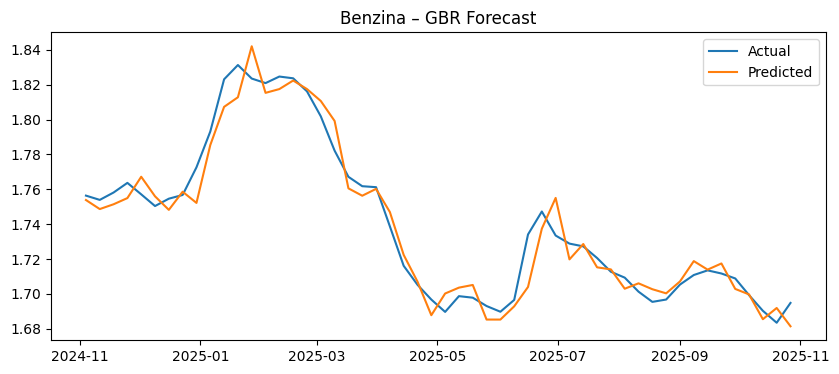

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df['date'].iloc[-52:], y_test_b, label='Actual')
plt.plot(df['date'].iloc[-52:], gbr_b.predict(X_test), label='Predicted')
plt.title('Benzina – GBR Forecast')
plt.legend()
plt.show()

In [10]:
y_test_b.tail()


1035    1.70886
1036    1.69929
1037    1.69031
1038    1.68346
1039    1.69483
Name: benzina_next, dtype: float64

In [11]:
y_pred_b = gbr_b.predict(X_test)
y_pred_b

array([1.75383232, 1.74864703, 1.75139798, 1.75494646, 1.7671784 ,
       1.75595934, 1.74819035, 1.75859394, 1.75217583, 1.78533325,
       1.80725164, 1.81276279, 1.84199559, 1.81528683, 1.81745673,
       1.82234941, 1.81745673, 1.81062486, 1.79916344, 1.76052291,
       1.75629691, 1.76021159, 1.7469483 , 1.72236019, 1.70703236,
       1.68778185, 1.70022617, 1.70359355, 1.70513045, 1.68528956,
       1.68527834, 1.6928725 , 1.70398533, 1.7373911 , 1.75503707,
       1.71980092, 1.72859859, 1.71524209, 1.71405064, 1.70297439,
       1.7060593 , 1.70268459, 1.7003211 , 1.70714665, 1.71879857,
       1.71391944, 1.71745292, 1.70285696, 1.69970415, 1.6854915 ,
       1.69191867, 1.68143564])